In [79]:
# Imports

import keras
from os import listdir
from numpy import array
from keras.models import Model
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint

import pandas as pd

In [80]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import tensorflow
import wandb

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [81]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [82]:
BASE_DIR = 'archive'
WORKING_DIR = 'working'

In [83]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "model_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

In [ ]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [84]:
# load features
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [85]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [86]:
# create mapping of image to captions
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 1070006.01it/s]


In [87]:
len(mapping)

8091

In [88]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption, saying "startseq" or "endseq"
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [89]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [90]:
# preprocess the text
clean(mapping)

In [91]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [92]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [93]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [94]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [95]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)

In [96]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [97]:
# generates batches of data for training
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    # X1 is image features, X2 is input sequence, y is output sequence
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    # in_seq is all the tokens up the current token, out_seq is the next token in the sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    # EXPLAIN THIS, DRAW AN IMAGE
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [98]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [99]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [ ]:
import wandb
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Bidirectional, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD

def define_model(config):
    # Image feature extractor
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.4)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    fe2_repeated = RepeatVector(max_length)(fe2)

    # Sequence processor
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.4)(se1)
    
    combined_input = Concatenate()([fe2_repeated, se2]) 
    se3 = Bidirectional(LSTM(256, return_sequences=False))(combined_input)

    # Output layer for predicting the next word directly
    outputs = Dense(vocab_size, activation='softmax')(se3)  
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    
    if config.optimizer == 'Adam':
        optimizer = Adam(learning_rate=config.learning_rate)
    else:
        optimizer = SGD(learning_rate=config.learning_rate)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)
    return model

from nltk.translate.bleu_score import corpus_bleu

def trainING():
    with wandb.init() as run:
        config = wandb.config
        model = define_model(config)
        epochs = config.epochs
        batch_size = config.batch_size
        steps = len(train) // batch_size

        for i in range(epochs):
            generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
            history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
            loss = history.history['loss'][0]
            wandb.log({"epoch": i, "loss": loss})

        model.save(f'model_{loss}_.h5')

        actual, predicted = [], []
        for key in test:
            actual_captions = [d.split() for d in mapping[key]]
            predicted_caption = predict_caption(model, features[key], tokenizer, max_length)
            predicted.append(predicted_caption.split())
            actual.append(actual_captions)
        bleu_1 = corpus_bleu(actual, predicted, weights=(1, 0, 0, 0))
        bleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
        wandb.log({"BLEU-1": bleu_1, "BLEU-2": bleu_2})

sweep_config = {
    'method': 'bayes',
    'metric': {
        'name' : 'loss',
        'goal' : 'minimize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.001, 0.0005, 0.005]
        },
        'epochs': {
            'values': [20,30]
        },
        'batch_size': {
            'values': [32, 16]
        },
        'optimizer': {
            'values': ['Adam', 'sgd']
        },
        'dropout': {
            'values': [0.4, 0.5, 0.6]
        }
    },
    "early_terminate": {
        "type": "hyperband",
        "eta": 3,
        "min_iter":3,
        "max_iter": 90
     }
}

sweep_id = wandb.sweep(sweep_config, project='sweep-laptop-2')
wandb.agent(sweep_id, trainING)


In [ ]:
model.save(WORKING_DIR+'/model.h5')

In [101]:
# load model
from tensorflow.keras.models import load_model
model = load_model(WORKING_DIR + '/model_2.237173080444336_.h5')

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score - spend a paragraph explaining this
# takes each word individually and scores
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))

# takes pairs of words and score based on that
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

In [100]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):

    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq black dog and white dog are playing with toy endseq


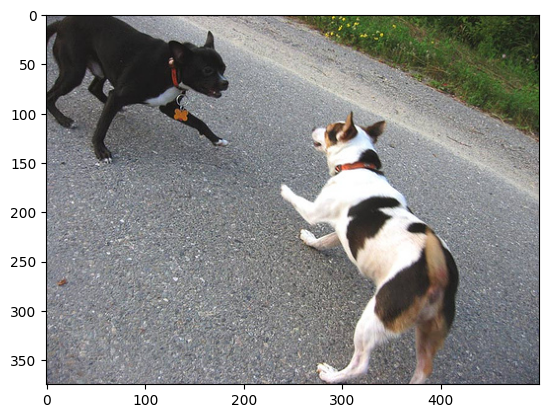

In [102]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq little girl in purple shirt is sitting in front of white canvas with rainbow endseq


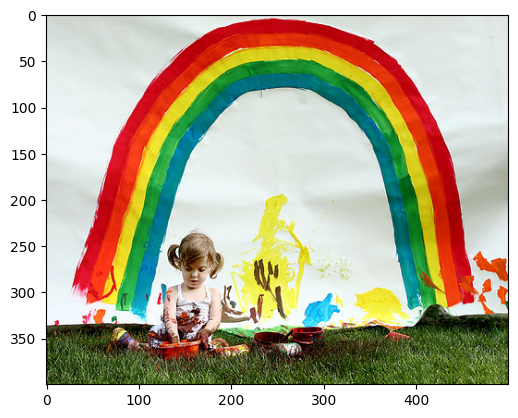

In [26]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq man lays on bench while his dog sits by him endseq
startseq man lays on the bench to which white dog is also tied endseq
startseq man sleeping on bench outside with white and black dog sitting next to him endseq
startseq shirtless man lies on park bench with his dog endseq
startseq man laying on bench holding leash of dog sitting on ground endseq
--------------------Predicted--------------------
startseq man in black shirt is sitting on bench with his dog endseq


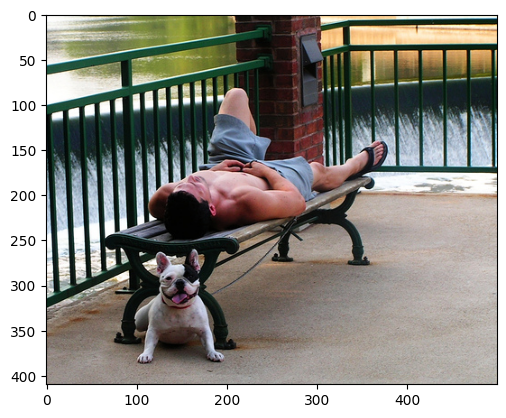

In [103]:
generate_caption("1003163366_44323f5815.jpg")

---------------------Actual---------------------
startseq group of people jump into lake in unison endseq
startseq three boys diving into lake endseq
startseq three boys in swimming trunks are diving into the lake endseq
startseq three people diving into water endseq
startseq three young men wearing colorful swim trunks are diving into the water endseq
--------------------Predicted--------------------
startseq man in wetsuit jumping into water endseq


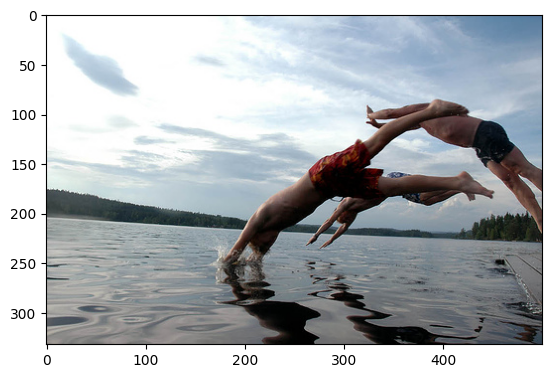

In [104]:
generate_caption("199809190_e3f6bbe2bc.jpg")

---------------------Actual---------------------
startseq two dolphins flying headfirst into beautiful tropical blue lake endseq
startseq two dolphins jumped out of the water in this zoo endseq
startseq two dolphins jumping into the water endseq
startseq two dolphins jump out of the blue water with palm trees behind them endseq
startseq two dolphins jump out of the water together endseq
--------------------Predicted--------------------
startseq two dolphins swimming in the water endseq


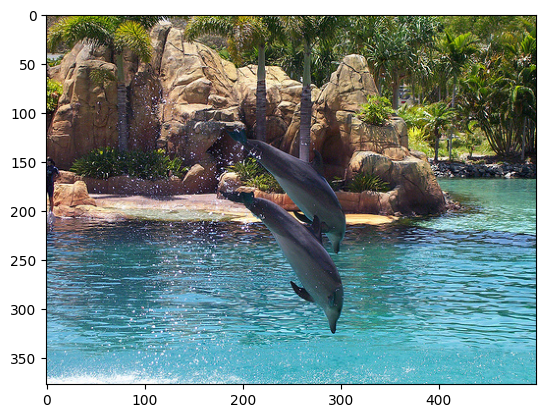

In [106]:
generate_caption("225699652_53f6fb33cd.jpg")

# Unseen Image Processing & Display

1/1 [==============================] - 0s 98ms/step
Generated Caption: startseq the man is climbing rock wall


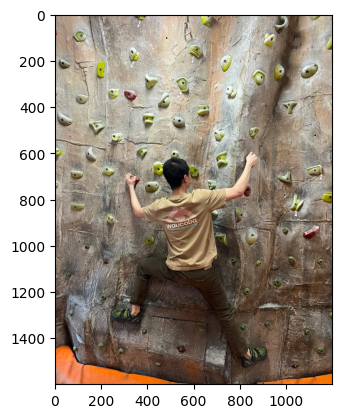

In [108]:
import numpy as np
import pickle
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer

# Function to load and prepare the image in the same way as during the training
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image

# Function to extract features from an image
def extract_features(image_path, model):
    image = preprocess_image(image_path)
    features = model.predict(image)
    return features

# Function to map an integer to a word
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Function to generate a caption for an image
def generate_caption(image_path, feature_model, caption_model, tokenizer, max_length=35):
    # Extract features using the feature model
    features = extract_features(image_path, feature_model)

    # Seed the generation process
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = np.pad(sequence, (0, max_length-len(sequence)), 'constant')
        sequence = np.expand_dims(sequence, axis=0)
        yhat = caption_model.predict([features, sequence], verbose=0)
        yhat = np.argmax(yhat, axis=-1)
        word = idx_to_word(yhat[0], tokenizer)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return in_text

# Path to the unseen image
unseen_image_path = 'climb.jpg'

# Load the pretrained VGG16 model
vgg_model = VGG16()
feature_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

# Load the trained caption generation model
caption_model_path = 'working/model_2.237173080444336_.h5'
caption_model = load_model(caption_model_path)

# Load the tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Generate the caption
caption = generate_caption(unseen_image_path, feature_model, caption_model, tokenizer)
print("Generated Caption:", caption)
image = load_img(unseen_image_path)
plt.imshow(image)

